In [1]:
from givenencoder import Encoder
import torch
import numpy as np
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from nltk.tokenize import sent_tokenize as ST

In [2]:
W2V_PATH = "/home/jingjing/Desktop/InferSent-master/dataset/GloVe/glove.840B.300d.txt"

In [3]:
f = open('/home/jingjing/Desktop/big.txt', 'r')
data = f.read()
splat = data.split("\n\n")

In [4]:
paragraphs = splat

In [5]:
sentences = ['Doctors lead a hard life.',
             'Their life is very busy.',
             'They get up early in the morning and go to the hospital.']
data = []
for p in paragraphs:
    nl = ST(p)
    if len(nl) > 1:
        data.append(ST(p))

In [6]:
f = Encoder()

f.zero_grad()

f.set_w2v_path(W2V_PATH)


In [7]:
def make_target(context_size, dim):
    targets = np.zeros((dim, dim))
    ctxt_sent_pos = list(range(-context_size, context_size+1))
    ctxt_sent_pos.remove(0)
    for ctxt in ctxt_sent_pos:
        targets += np.eye(dim, k=ctxt)
    targets_sum = np.sum(targets,axis=1, keepdims=True)
    targets = targets / targets_sum
    targets = torch.from_numpy(targets)
    return targets

In [8]:
def loss_fn(pred, target):
    mask = 1 - torch.diag(torch.ones(pred.size(1)))
    npred = pred * mask
    s_pred = F.softmax(npred, -1)
    ln = nn.BCELoss(size_average=False)
    losses = ln(s_pred, target)
    return losses

In [9]:
with torch.no_grad():
    f.build_vocab(sentences, True)
    embs = f.encode(sentences, 400, True, False)
    targets = make_target(1, len(sentences))
    loss = loss_fn(embs, targets.float())
    print("loss before training: ", loss)

Found 23(/23) words with w2v vectors
Vocab size : 23
loss before training:  tensor(3.7054)


In [11]:
optimizer = optim.Adam(f.parameters(), lr=0.0005)
nn.utils.clip_grad_norm_(f.parameters(), 5)

0.0

In [12]:
print(len(data))

89715


In [25]:
trdata = [[i] for i in range(50)]
for epoch in range(10):
    i = 0
    for instance in data[:3]:
        optimizer.zero_grad()
        #if epoch == 0:
        #    f.build_vocab(instance, True)
        #f.build_vocab(instance, True)
        targets = make_target(1, len(instance))
        scores = f.encode(instance, 400)
        loss = loss_fn(scores, targets.float())
        #print(loss)
        trdata[i].append(loss.item())
        i += 1
        loss.backward()
        optimizer.step()

In [32]:
with torch.no_grad():
    f.build_vocab(sentences, True)
    embeddings = f.encode(sentences, 400)
    targets = make_target(1, len(sentences))
    loss = loss_fn(embeddings, targets.float())
    print("loss after training: ", loss)

Found 23(/23) words with w2v vectors
Vocab size : 23
loss after training:  tensor(5.6465)


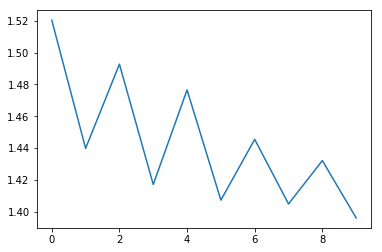

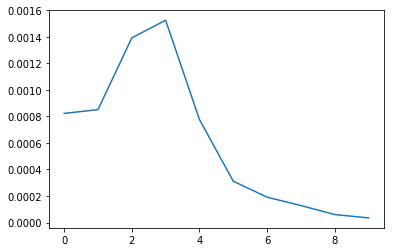

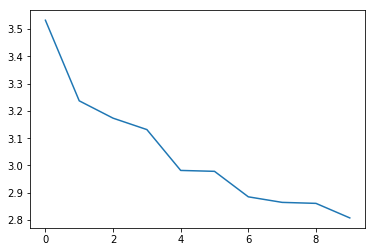

In [26]:
import matplotlib.pyplot as plt

for i in range(3):
    plt.figure(i)
    plt.plot(trdata[i][1:])
    plt.show()


In [15]:
trdata[0]

[0,
 4.1722283363342285,
 1.9811714887619019,
 1.7569588422775269,
 1.5284161567687988,
 1.4439995288848877,
 1.4134989976882935,
 1.4963237047195435,
 1.5102678537368774,
 1.4848254919052124,
 1.5322985649108887]